In [45]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

from pyclustering.cluster.kmedians import kmedians

from pyclustering.utils import draw_clusters
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall

import seaborn as sn

sn.set_theme()

def kmedians_clustering(k, data, iterations = 20, tolerance = 0.001):
    start_centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
    min_instance = kmedians(data, start_centroids, tolerance)
    (ticks, result) = timedcall(min_instance.process)
    min_sse = min_instance.get_total_wce()

    for i in range(iterations):
        start_centroids = data[np.random.choice(data.shape[0], k, replace=False), :]
        kmedians_instance = kmedians(data, start_centroids, tolerance)
        (ticks, result) = timedcall(kmedians_instance.process)

        this_sse = kmedians_instance.get_total_wce()
        if (this_sse < min_sse):
            min_instance = kmedians_instance
            min_sse = this_sse

    return min_instance

def get_kmedians_labels(df, kmedians_instance):
    num_entries, num_features = df.shape
    clusters = kmedians_instance.get_clusters()
    cluster_labels=np.empty(shape=(num_entries,))
    for clus_ind in range(len(clusters)):
        clus = clusters[clus_ind]
        for j in range(len(clus)):
            point = clus[j]
            cluster_labels[point] = clus_ind

    return cluster_labels

def plot_indicators(sse_list, sil_list, sep_list):
    # SSE
    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.xticks(range(2, len(sse_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_sse.png")
    plt.show()

    # Silhouette
    plt.plot(range(2, len(sil_list) + 2), sil_list)
    plt.ylabel('Silouettes')
    plt.xlabel('K')
    plt.xticks(range(2, len(sil_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_silouettes.png")
    plt.show()

    # Davies-Bouldin Score
    plt.plot(range(2, len(sep_list) + 2), sep_list)
    plt.ylabel('Separation')
    plt.xlabel('K')
    plt.xticks(range(2, len(sep_list) + 2))
    plt.savefig("../images/alternative_clustering/kmeans_separation.png")
    plt.show()

def k_medians(df, max_k, initial_iterations=20):
    sse_list = list()
    separations = list()
    silouettes = list()
    kmedians_minmax_instance = list()

    num_entries, num_features = df.shape
    points = np.zeros((num_entries, num_features))
    for i in range(num_entries):
        for j in range(num_features):
            points[i][j] = df.iloc[i, j]
    
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Iterating over {0} possible K values".format(max_k)):        
        kmedians_instance = kmedians_clustering(k, points, iterations=initial_iterations)
        kmedians_minmax_instance.append(kmedians_instance)
        
        cluster_labels = get_kmedians_labels(df, kmedians_instance)
        
        separations.append(davies_bouldin_score(df, cluster_labels))
        silouettes.append(silhouette_score(df, cluster_labels))
        sse = kmedians_instance.get_total_wce()
        sse_list.append(sse)
    
    return sse_list, silouettes, separations, kmedians_minmax_instance

In [2]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_no_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: total: 156 ms
Wall time: 353 ms


In [3]:
df_clustering = df_users.copy()

In [4]:
# delete categorical attributes
del df_clustering['name']
del df_clustering['lang']
del df_clustering['bot']
del df_clustering['created_at']

In [5]:
df_clustering.statuses_count = np.log(df_clustering.statuses_count + 1)
df_clustering.tweet_count = np.log(df_clustering.tweet_count + 1)
df_clustering.retweet_made_ratio = np.log(df_clustering.retweet_made_ratio + 1)
df_clustering.reply_count_avg = np.log(df_clustering.reply_count_avg + 1)
df_clustering.favorite_count_avg = np.log(df_clustering.favorite_count_avg + 1)
df_clustering.tweet_length_avg = np.log(df_clustering.tweet_length_avg + 1)
df_clustering.num_special_chars_avg = np.log(df_clustering.num_special_chars_avg + 1)
df_clustering.reply_count_entropy = np.log(df_clustering.reply_count_entropy + 1)
df_clustering.favorite_count_entropy = np.log(df_clustering.favorite_count_entropy + 1)
df_clustering.num_hashtags_entropy = np.log(df_clustering.num_hashtags_entropy + 1)
df_clustering.num_urls_entropy = np.log(df_clustering.num_urls_entropy + 1)
df_clustering.tweet_length_entropy = np.log(df_clustering.tweet_length_entropy + 1)

In [6]:
df_clustering = df_clustering[["statuses_count", "retweet_made_ratio", "elapsed_time_entropy"]].copy()

In [7]:
df_clustering.describe()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
count,11508.000000,11508.000000,11508.000000
mean,5.606388,0.080843,2.472382
std,2.634090,0.135644,1.199069
min,0.000000,0.000000,0.000000
25%,3.761200,0.000000,1.324296
50%,4.276666,0.000000,2.540036
75%,7.832510,0.117783,3.479779
max,12.898109,0.693147,5.757547


In [8]:
df_clustering.head()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
2353593986,4.343805,0.000000,1.364257
2358850842,4.007333,0.000000,1.335474
137959629,1.386294,0.000000,0.693147
466124818,3.931826,0.004695,4.130876
2571493866,8.865876,0.000000,2.868727


In [9]:
def visualize_cluster_centers(df, kmedians_instance, columns=pd.DataFrame()):
    if (columns.empty):
        columns = df.columns
    plt.figure(figsize=(8, 4))
    centers = kmedians_instance.get_medians()
    for i in range(0, len(centers)):
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(columns)), columns)
    plt.legend()
    plt.show()

## MinMax

In [10]:
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(scaler_minmax.fit_transform(df_clustering.values))

In [32]:
sse_minmax, sil_minmax, davies_bouldin_minmax, kmedians_minmax_instance = k_medians(X_minmax, 8, initial_iterations=100)

Iterating over 8 possible K values: 100%|██████████| 7/7 [07:35<00:00, 65.10s/it]


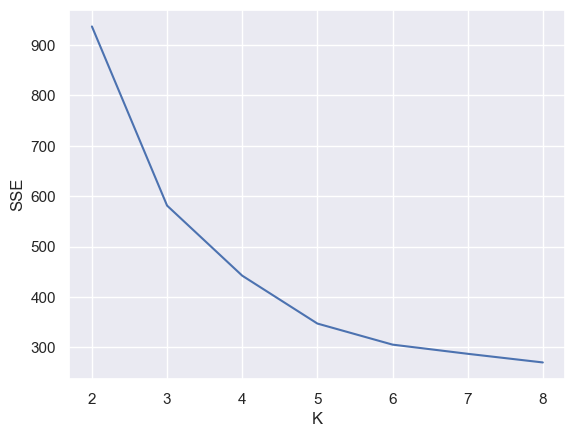

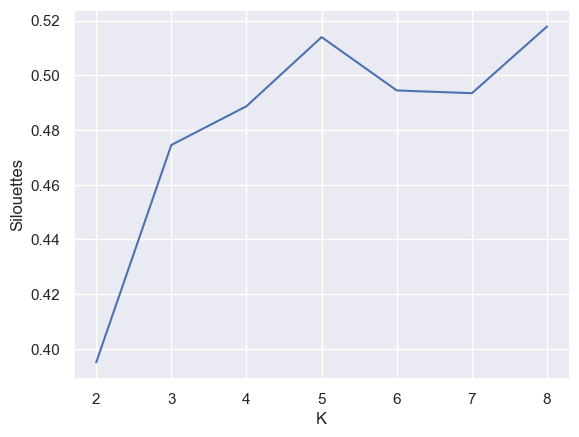

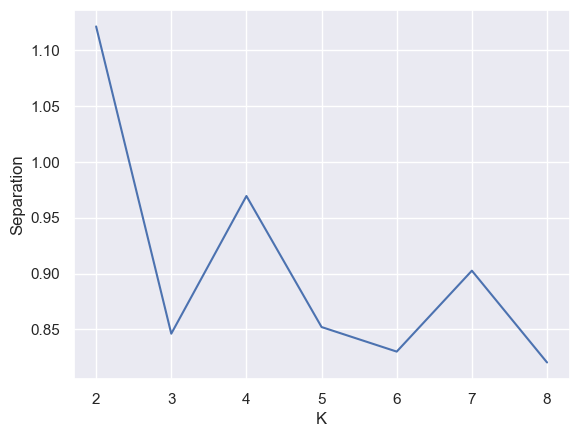

In [33]:
plot_indicators(sse_minmax, sil_minmax, davies_bouldin_minmax)

In [34]:
best_k = 5  # best k value

kmedians_instance = kmedians_minmax_instance[best_k-2]
cluster_labels = get_kmedians_labels(df_clustering, kmedians_instance)
print("SSE:", sse_minmax[best_k-2], " - SILHOUETTE:", sil_minmax[best_k-2])

SSE: 347.3473097150778  - SILHOUETTE: 0.5139747808662056


In [46]:
davies_bouldin_minmax[best_k-2]

0.8521467801935325

In [35]:
df_cluster = df_clustering.copy()
cluster_labels = get_kmedians_labels(X_minmax, kmedians_instance)
df_cluster["cluster"] = cluster_labels  # insert the column "cluster"
df_cluster.groupby("cluster").mean()

,statuses_count,retweet_made_ratio,elapsed_time_entropy
cluster,,,
0.0,3.732451,0.005053,1.254608
1.0,7.769777,0.150391,3.879448
2.0,3.801315,0.021027,3.422217
3.0,8.659334,0.395351,2.375962
4.0,9.271775,0.059498,1.862328


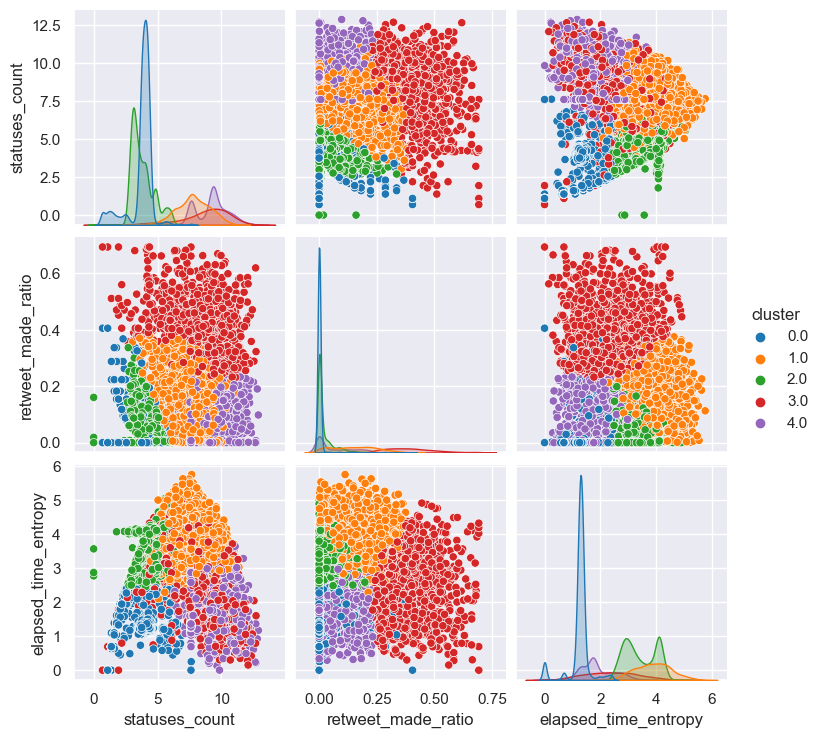

In [36]:
sn.pairplot(df_cluster, hue='cluster', palette='tab10')

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

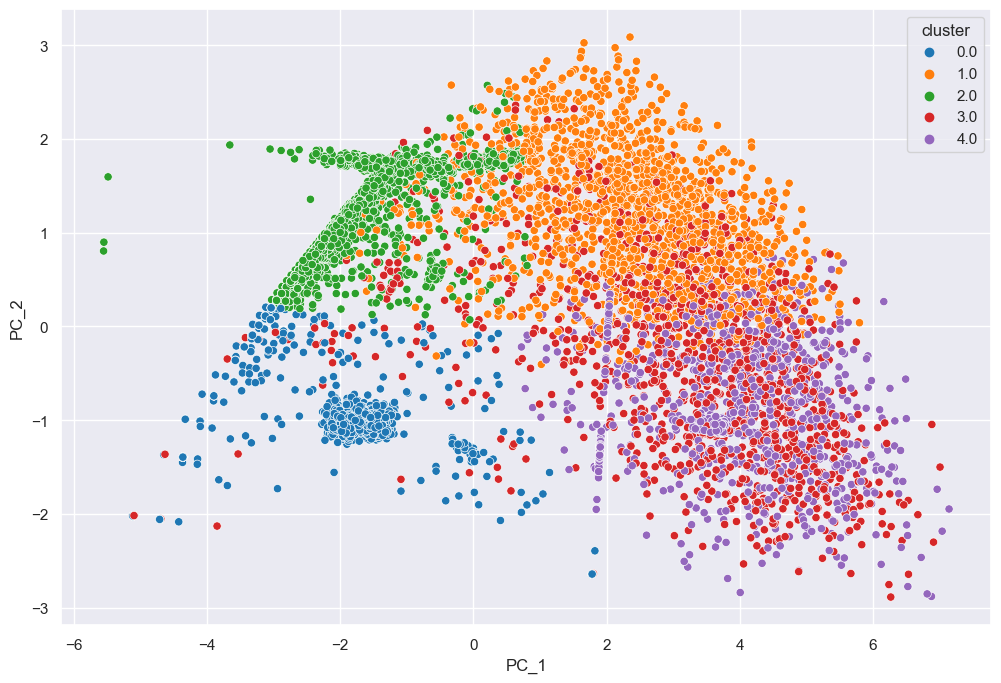

In [37]:
pca = PCA(n_components=2)
data_to_visualize = pd.DataFrame(pca.fit_transform(df_clustering), columns=['PC_1','PC_2'], index=df_clustering.index)
data_to_visualize['cluster'] = pd.Categorical(cluster_labels)
plt.figure(figsize=(12,8))
sn.scatterplot(x="PC_1", y="PC_2", hue="cluster", data=data_to_visualize, palette='tab10')

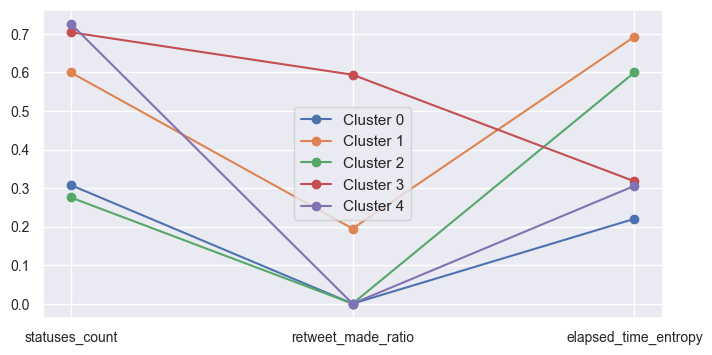

In [38]:
visualize_cluster_centers(df_clustering, kmedians_instance, columns=df_clustering.columns)

In [39]:
def pie_of_bot_pct(bot_pct, num_clusters):
    labels = []
    for k in range(0, num_clusters):
        labels.append('Cluster '+str(k))

    fig = plt.figure(figsize=(12, 8))
    plt.subplots_adjust(wspace=0.5)

    ax = fig.add_subplot(121)
    ax.pie(bot_pct[0], labels = labels, autopct='%.0f%%')
    ax.set_title("Real users per cluster")

    ax = fig.add_subplot(122)
    ax.pie(bot_pct[1], labels = labels, autopct='%.0f%%')
    ax.set_title("Bots per cluster")
    plt.show()

In [40]:
bot_pct = pd.crosstab(cluster_labels, df_users['bot'])
bot_pct

bot,0,1
row_0,,
0.0,1011,2758
1.0,1526,247
2.0,700,2569
3.0,1154,83
4.0,1001,459


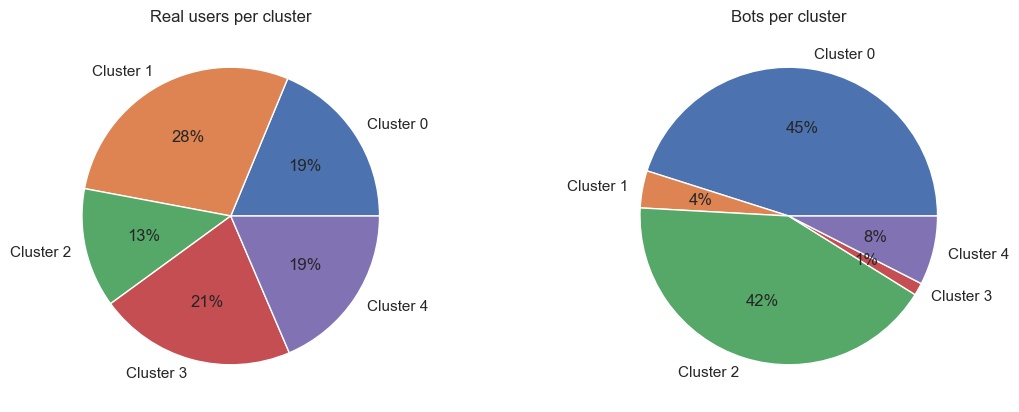

In [41]:
pie_of_bot_pct(bot_pct, best_k)

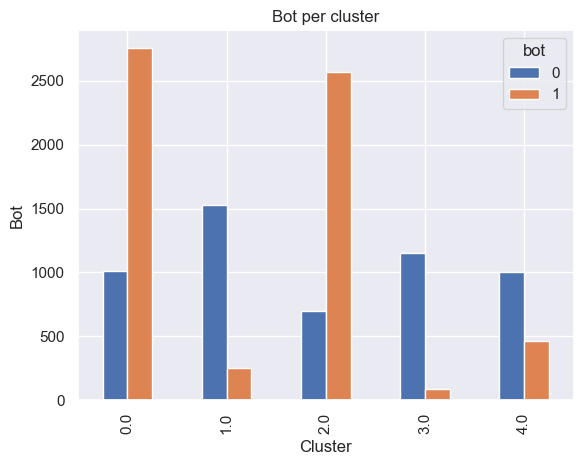

In [42]:
bot_pct.plot(kind='bar', stacked=False, title='Bot per cluster')
plt.xlabel('Cluster')
plt.ylabel('Bot')
plt.show()

In [43]:
df_minmax_centers = pd.DataFrame(scaler_minmax.inverse_transform(kmedians_instance.get_medians()), columns=df_clustering.columns)
df_minmax_centers

,statuses_count,retweet_made_ratio,elapsed_time_entropy
0,3.970292,0.000000,1.267523
1,7.739794,0.134979,3.988833
2,3.555348,0.000000,3.454499
3,9.084664,0.411834,1.828520
4,9.372459,0.000000,1.759778


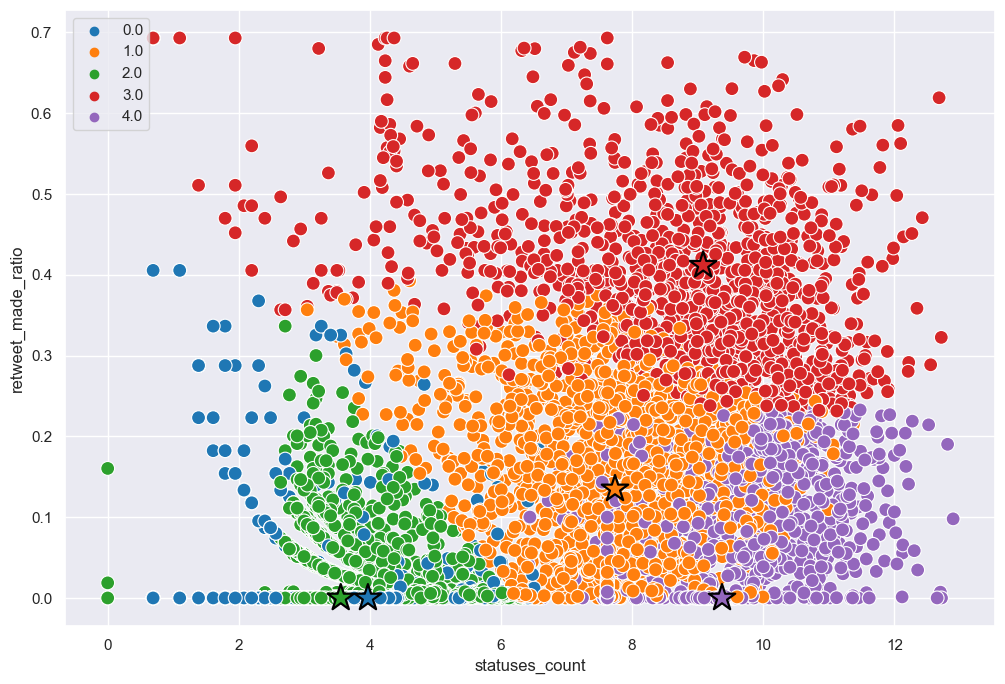

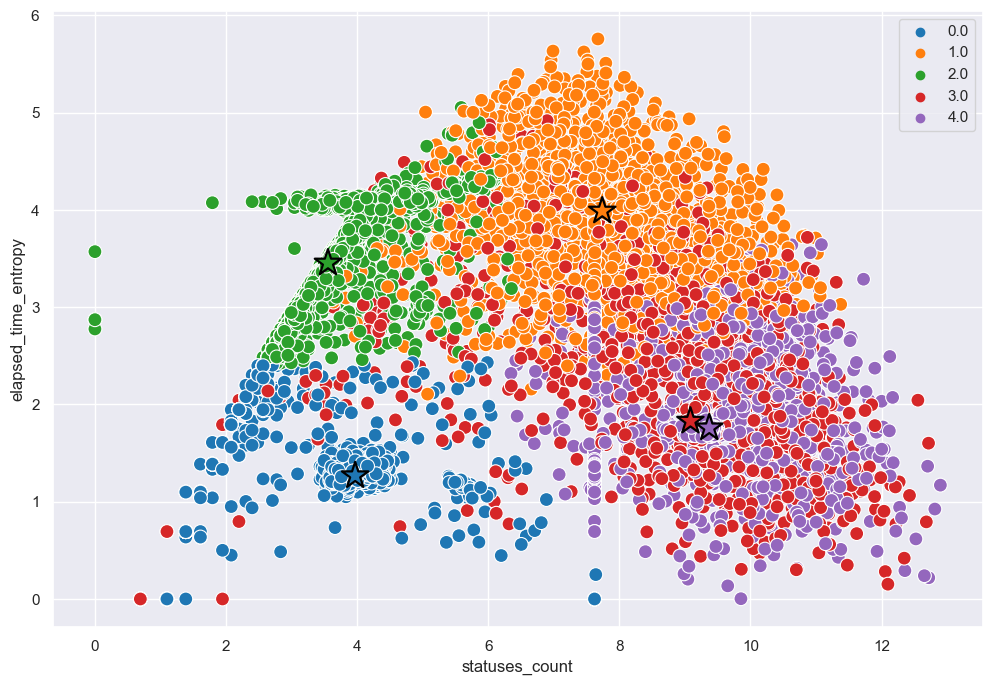

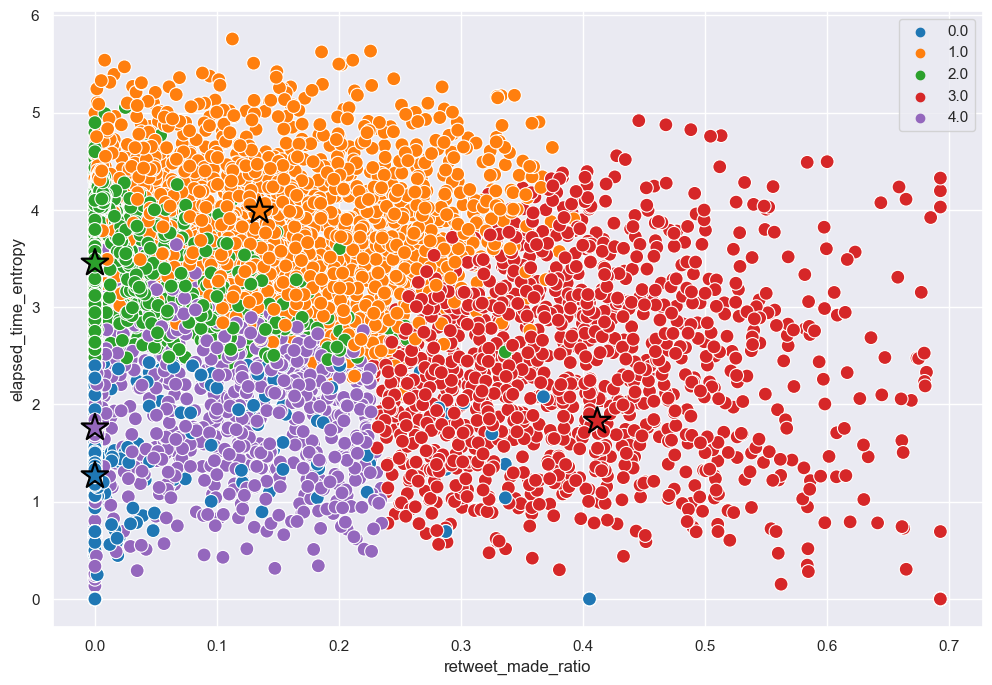

In [44]:
for i in range(df_clustering.shape[1]):
    for j in range(i):
        plt.figure(figsize=(12, 8))
        ax = sn.scatterplot(x=df_clustering.columns[j], y=df_clustering.columns[i], data=df_cluster, hue=cluster_labels, palette="tab10", s=100)
        ax = sn.scatterplot(x=df_clustering.columns[j], y=df_clustering.columns[i], data=df_minmax_centers, label='centroid',
                            hue=range(best_k), palette="tab10", marker='*', s=400, ec='black', legend=False, ax=ax)
        plt.show()

## Standard Scaler

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(df_clustering.values))

In [ ]:
sse_std, sil_std, davies_bouldin_std = k_medians(X_std, 20)

In [ ]:
plot_indicators(sse_std, sil_std, davies_bouldin_std)

In [ ]:
best_k = 6  # best k value
num_entries, num_features = X_minmax.shape
points = np.zeros((num_entries, num_features))
for i in range(num_entries):
    for j in range(num_features):
        points[i][j] = X_minmax.iloc[i, j]

kmedians_instance = kmedians_clustering(best_k-2, points, iterations=1)
print("SSE:", sse[best_k-2], " - SILHOUETTE:", sil[best_k-2])
print("THIS RUN SILHOUETTE:", silhouette_score(df_clustering, cluster_labels))
print("THIS RUN SSE:", kmedians_instance.get_total_wce())